In [7]:
1 + 1

2

In [2]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, cascadelake)
Environment:
  JULIA_NUM_THREADS = 4
      Status `/mnt/efs/kai/projects/AdvancedHMC.jl/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.0 `../..#kx/rhmc-draft`
  [6e4b80f9] BenchmarkTools v1.3.2
  [863f3e99] Comonicon v1.0.4
  [163ba53b] DiffResults v1.1.0
  [31c24e10] Distributions v0.24.18
  [366bfd00] DynamicPPL v0.10.20
  [6a86dc24] FiniteDiff v2.17.0
  [f6369f11] ForwardDiff v0.10.35
  [6d524b87] MCMCDebugging v0.2.0
  [91a5bcdd] Plots v1.38.6
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.9.0
  [a8a75453] StatProfilerHTML v1.5.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl#main`


In [3]:
using PyPlot: PyPlot; const plt = PyPlot
using Statistics, AdvancedHMC
includet("../src/relativistic_hmc.jl")
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc-sampler.jl")

┌ Warning: skipping callee #step#16 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils /home/kai/.julia/packages/LoweredCodeUtils/0oUEK/src/signatures.jl:292


In [4]:
using FiniteDiff: finite_difference_gradient, finite_difference_hessian, finite_difference_jacobian
using AdvancedHMC: neg_energy, energy

let hps = (; λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)
    
    target = Funnel()

    rng = MersenneTwister(1110)

    θ₀ = randn(rng, dim(target))

    ℓπ = VecTargets.gen_logpdf(target)
    ∂ℓπ∂θ = VecTargets.gen_logpdf_grad(target, θ₀)

    Vfunc, Hfunc, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    D = dim(target) # ==2 for this test
    x = zeros(D) # randn(rng, D)
    r = randn(rng, D)
    
    # metric = UnitEuclideanMetric(D)
    # metric = DiagEuclideanMetric(D)
    # metric = DenseEuclideanMetric((D,))
    
    hessmap = SoftAbsMap(hps.α)
    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, hessmap)
    
    kinetic = RelativisticKinetic(1.0, 1.0)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    Hamifunc = (x, r) -> energy(hamiltonian, r, x) + energy(hamiltonian, x)
    Hamifuncx = x -> Hamifunc(x, r)
    Hamifuncr = r -> Hamifunc(x, r)

    @show finite_difference_gradient(Hamifuncx, x), ∂H∂θ(hamiltonian, x, r).gradient

    @show finite_difference_gradient(Hamifuncr, r), ∂H∂r(hamiltonian, x, r)

end

(finite_difference_gradient(Hamifuncx, x), (∂H∂θ(hamiltonian, x, r)).gradient) = ([0.784203846230777, 1.4239110034470495], [0.8090728208833031, 1.312496255281786])
(finite_difference_gradient(Hamifuncr, r), ∂H∂r(hamiltonian, x, r)) = ([1.6428101428835526, 0.6543716192698452], [1.6428101429724244, 0.6543716193079193])


([1.6428101428835526, 0.6543716192698452], [1.6428101429724244, 0.6543716193079193])

In [5]:
let x = randn(2)
    
    M = randn(2, 2)
    @show M
    M = M' * M
    
    f = M -> begin
        cholesky(Symmetric(M)).U
    end
    
    @show finite_difference_jacobian(f, M) 2 * x' .* (M * x)
end

M = [0.7756458124449415 -0.433417648186973; 1.2634438585842545 1.2798411545246775]
finite_difference_jacobian(f, M) = [0.3372596412067917 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -0.19653695866357074 0.0 0.674519286397743 0.0; 0.1634290913920169 0.0 -0.560892360525924 0.4812487953359523]
(2 * x') .* (M * x) = [-0.6080315426149339 5.1893495721433895; -0.9957202550114059 8.498145436823652]


2×2 Matrix{Float64}:
 -0.608032  5.18935
 -0.99572   8.49815

Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


 86.541969 seconds (850.66 M allocations: 53.581 GiB, 16.04% gc time, 2.25% compilation time)
Quantile error: 0.00817


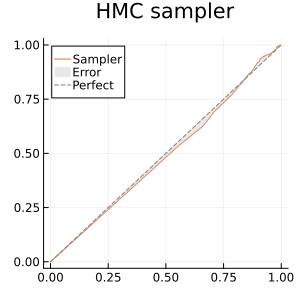

In [106]:
using Distributions, DynamicPPL

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringFunnel(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 3)
    s = exp(θ[1] / 2)
    θ[2] ~ Normal(0, s)
    x ~ Normal(0, s)
    return θ, x
end

# Sanity check for normal HMC
function rand_θ_given_hmc(target, hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)

    # metric = UnitEuclideanMetric(D)
    metric = DiagEuclideanMetric(D)
    # metric = DenseEuclideanMetric(D)
    # kinetic = GaussianKinetic()
    kinetic = RelativisticKinetic(hps.m, hps.c)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given_hmc(hps, target) = x -> rand_θ_given_hmc(hps, target, x)

g(θ, x) = cat(θ, x; dims=1)

using MCMCDebugging
using Logging: NullLogger, with_logger

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, m=1.0, c=1.0, ϵ=0.1, n=6, L=8)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given_hmc(Funnel(3), hps_geweke); g=g)
end

using Plots: Plots

Plots.plot(res, TuringFunnel(); size=(300, 300), title="HMC sampler")

 17.756591 seconds (48.40 M allocations: 4.049 GiB, 4.85% gc time, 1.96% compilation time)


┌ Info: Average acceptance ratio
│   mean(map((s->begin
                #= In[98]:11 =#
                s.is_accept
            end), retval.stats)) = 0.784
└ @ Main In[98]:11


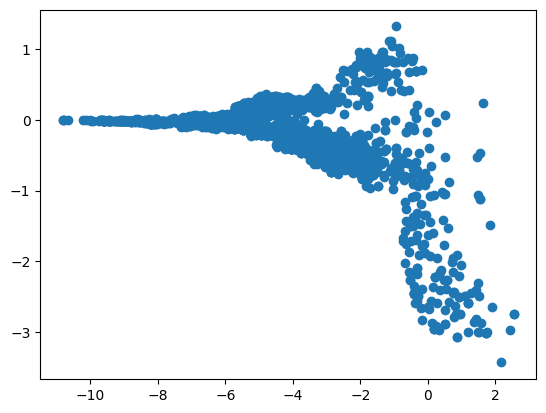

In [98]:
using Logging: NullLogger, with_logger

hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, m=1.0, c=1.0, integrator=:lf, ϵ=0.05, n=6, L=8)

@time retval = with_logger(NullLogger()) do 
    # sample_target((; hps..., target=:funnel, kinetic=:relativistic, integrator=:glf))
    # sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, kinetic=:gaussian, integrator=:glf))
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, kinetic=:relativistic, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

In [75]:
# I still need to use the hand-written one because of AD
function rand_θ_given(hps, target, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    
    D = dim(target) - 1
    θ₀ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    ∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, θ₀)
    
    _, _, Gfunc, ∂G∂θfunc = prepare_sample_target(hps, θ₀, ℓπ)

    metric = DenseRiemannianMetric((D,), Gfunc, ∂G∂θfunc, SoftAbsMap(hps.α))
    kinetic = RelativisticKinetic(hps.m, hps.c)
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, θ₀, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

make_rand_θ_given(hps, target) = x -> rand_θ_given(hps, target, x)

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, m=1.0, c=1.0, ϵ=0.1, n=6, L=8)

@time res_1 = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, make_rand_θ_given(hps_geweke, Funnel(3)); g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:17:33


1053.588465 seconds (2.60 G allocations: 218.526 GiB, 4.28% gc time, 1.74% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [32.650462383260184, -0.6878467790154144, 0.7014097412461777]
    P-value: [7.893018384429515e-234, 0.4915492743785214, 0.4830473444913437]


Quantile error: 0.02415


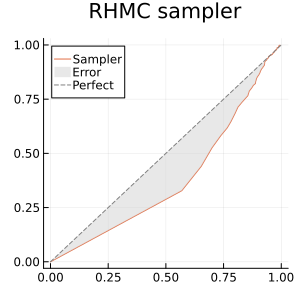

In [76]:
Plots.plot(res_1, TuringFunnel(); size=(300, 300), title="RHMC sampler")

In [29]:
using Profile

@profile sample_target((; hps..., target=:funnel, n_samples=200, metric=:dense_riemannian_softabs, integrator=:glf))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/hamiltonian.jl:49
┌ Info: Finished 200 sampling steps for 1 chains in 16.212777962 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 0.5777887188587003
│   average_acceptance_rate = 0.9082725352762563
└ @ AdvancedHMC /home/kai/.julia/packages/AdvancedHMC/2Djs8/src/sampler.jl:214


(target = Funnel(dim=2), hamiltonian = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic()), samples = [[0.1651631528127426, 0.49589378510546067], [0.5315666395079818, 0.5015587307587007], [0.45397313844926, -0.5700686191598574], [4.876272646702477, 2.610052555898302], [4.371761409588581, 7.692358809831473], [3.913860022468956, 8.878160709917596], [3.9280292240196997, 9.000617096814542], [3.27462078472426, 9.96712952204592], [3.0591736965848226, 8.885603659137091], [2.509213682550947, 8.378121208987343]  …  [0.5662388079878391, -1.2162693015006223], [1.0489283265843259, -1.8089138371222993], [-1.8221662100636895, -0.4641748332337326], [-2.3012189452869234, 0.038561101178192274], [0.6747029432886454, 0.2553206804904393], [1.577641265333467, 1.0296963842887827], [1.061350141312465, 0.606467535911618], [-0.22841508459186116, -0.8234290688634257], [-0.2896251193536631, -1.2672704342781111], [0.5066675582283443, -0.2861746176231629]], stats = NamedTuple[(n_steps = 8, is

In [30]:
using StatProfilerHTML

statprofilehtml()

┌ Info: Wrote profiling output to file:///mnt/efs/kai/projects/AdvancedHMC.jl/research/tests/statprof/index.html .
└ @ StatProfilerHTML /home/kai/.julia/packages/StatProfilerHTML/DKdvQ/src/StatProfilerHTML.jl:28


In [109]:
using BenchmarkTools, DiffResults, ForwardDiff

function gen_hess_fwd(func, x::AbstractVector)
    function hess(x::AbstractVector)
        return nothing, nothing, ForwardDiff.hessian(func, x)
    end
    return hess
end

function gen_∂G∂θ_fwd(Vfunc, x; f=identity)
    _Hfunc = gen_hess_fwd(Vfunc, x)
    Hfunc = x -> _Hfunc(x)[3]
    # QUES What's the best output format of this function?
    cfg = ForwardDiff.JacobianConfig(Hfunc, x)
    d = length(x)
    out = zeros(eltype(x), d^2, d)
    return x -> ForwardDiff.jacobian!(out, Hfunc, x, cfg); out # default output shape [∂H∂x₁; ∂H∂x₂; ...]
end

let target = Funnel()
    
    θ₀ = [1.1, 2.2]
    
    ℓπ = VecTargets.gen_logpdf(target)
    Vfunc = x -> -ℓπ(x)
    
    fstabilize = H -> H + hps.λ * I
    ∂G∂θfunc_rev = gen_∂G∂θ_rev(Vfunc, θ₀; f=fstabilize)
    
    @show ∂G∂θfunc_rev(θ₀)
    
    ∂G∂θfunc_fwd = gen_∂G∂θ_fwd(Vfunc, θ₀; f=fstabilize)
    
    @show ∂G∂θfunc_fwd(θ₀)
    
    @btime $∂G∂θfunc_rev($θ₀)
    @btime $∂G∂θfunc_fwd($θ₀)
    
end

∂G∂θfunc_rev(θ₀) = [-0.8055480225493534 0.732316384135775; 0.7323163841357747 -0.33287108369807944; 0.7323163841357749 -0.33287108369807955; -0.33287108369807944 0.0]
∂G∂θfunc_fwd(θ₀) = [-0.805548022549354 0.732316384135775; 0.7323163841357748 -0.33287108369807944; 0.732316384135775 -0.33287108369807955; -0.33287108369807944 -0.0]
  1.725 ms (14060 allocations: 606.31 KiB)
  3.855 μs (38 allocations: 6.91 KiB)


4×2 Matrix{Float64}:
 -0.805548   0.732316
  0.732316  -0.332871
  0.732316  -0.332871
 -0.332871  -0.0

In [ ]:
1.764 ms -> 5.338 μs -> 3.651 μs

In [54]:
let f = x -> x'*x, x = [0.1, 0.2, 0.3], c=3, tag=ForwardDiff.Tag((f,ForwardDiff.gradient), eltype(x))
    
    resultcfg = ForwardDiff.HessianConfig(f, DiffResults.HessianResult(x), x, ForwardDiff.Chunk{c}(), tag)
    out = DiffResults.HessianResult(x)
    ForwardDiff.hessian!(out, f, x, resultcfg)
    
end

MutableDiffResult(0.14, ([0.2, 0.4, 0.6], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]))